In [1]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

In [24]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

import pytz

import astroplan
from astroplan import Observer, FixedTarget, ObservingBlock, SequentialScheduler

from astroplan import plots
color_cycle = plots.mplstyles.astropy_mpl_style['axes.color_cycle']

In [3]:
pal = Observer.at_site('Palomar', timezone=pytz.timezone('US/Pacific'))
pal

<Observer: name='Palomar',
    location (lon, lat, el)=(-116.86300000000001 deg, 33.356 deg, 1706.0000000002024 m),
    timezone=<DstTzInfo 'US/Pacific' LMT-1 day, 16:07:00 STD>>

In [4]:
midnight = pal.midnight(Time('2015-11-03 5:00'))
midnight

<Time object: scale='utc' format='jd' value=2457329.8159807464>

In [5]:
targets = [FixedTarget.from_name('Vega'),
           FixedTarget.from_name('Deneb'),
           FixedTarget.from_name('Altair'),
           FixedTarget.from_name('Albireo')]
targets

[<FixedTarget "Vega" at SkyCoord (ICRS): (ra, dec) in deg (279.23473479, 38.78368896)>,
 <FixedTarget "Deneb" at SkyCoord (ICRS): (ra, dec) in deg (310.35797975, 45.28033881)>,
 <FixedTarget "Altair" at SkyCoord (ICRS): (ra, dec) in deg (297.6958273, 8.8683212)>,
 <FixedTarget "Albireo" at SkyCoord (ICRS): (ra, dec) in deg (292.68033548, 27.95968007)>]

/home/erik/anaconda3/envs/astroplan/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


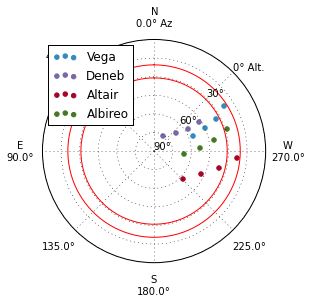

In [27]:
t1 = pal.twilight_evening_astronomical(midnight)
ts = t1 + [0, 1, 2, 3]*u.hour
for target, c in zip(targets, color_cycle):
    plots.plot_sky(target, pal, ts, style_kwargs=dict(color=c))
plt.plot(np.linspace(0,2*np.pi,100), [np.degrees(np.arccos(1/2))]*100, color='r')
plt.plot(np.linspace(0,2*np.pi,100), [np.degrees(np.arccos(1/3))]*100, color='r')
plt.legend(loc='upper left')

In [7]:
etime = 5*u.min
n = 10
rot = 55*u.second

blocks = [ObservingBlock.from_exposures(t, etime, n, rot) for t in targets]

In [8]:
blocks

[<astroplan.scheduling.ObservingBlock (Vega, unscheduled) at 0x7f44a503e240>,
 <astroplan.scheduling.ObservingBlock (Deneb, unscheduled) at 0x7f44a503ef98>,
 <astroplan.scheduling.ObservingBlock (Altair, unscheduled) at 0x7f44a503ec50>,
 <astroplan.scheduling.ObservingBlock (Albireo, unscheduled) at 0x7f44a503ad68>]

In [9]:
constraints = [astroplan.constraints.AirmassConstraint(3, boolean_constraint=False),
               astroplan.constraints.AtNightConstraint(18*u.deg)
               #,astroplan.constraints.MoonSeparationConstraint(5*u.deg)
               ]

In [10]:
start_time = pal.twilight_evening_astronomical(midnight)
end_time = pal.twilight_morning_astronomical(midnight)
scheduler = SequentialScheduler(start_time, end_time,
                                constraints=constraints, observer=pal)
schedule = scheduler(blocks)
schedule

[<astroplan.scheduling.ObservingBlock (Deneb, 2457329.598658881 to 2457329.6194922146) at 0x7f44a5a53a58>,
 <astroplan.scheduling.ObservingBlock (Albireo, 2457329.6194922146 to 2457329.6403255477) at 0x7f44a5a53d68>,
 <astroplan.scheduling.ObservingBlock (Altair, 2457329.6403255477 to 2457329.661158881) at 0x7f44a5a53828>,
 <astroplan.scheduling.ObservingBlock (Vega, 2457329.661158881 to 2457329.6819922146) at 0x7f44a5a38588>]

In [11]:
[b.constraints_value if hasattr(b, 'constraints_value') else None for b in schedule]

[0.91849454256487728,
 0.65465355072090725,
 0.3976055430830322,
 0.18583228682221511]

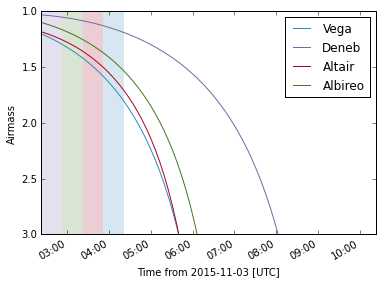

In [59]:
ts = start_time + np.linspace(0, (end_time-start_time).value, 100)*u.day
targ_to_color = {}
for target, c in zip(targets, color_cycle):
    plots.plot_airmass(target, pal, ts, style_kwargs=dict(color=c))
    targ_to_color[target.name] = c
plt.legend(loc=0)

for block in schedule:
    plt.axvspan(block.start_time.plot_date, block.end_time.plot_date, 
                fc=targ_to_color[block.target.name], lw=0, alpha=.2)
ax=plt.gca()